This code was adapted from the following repositories: "cnn-svm" [link to repo](https://github.com/AFAgarap/cnn-svm/blob/master/model/cnn_svm.py), and "Pytorch Sentiment Analysis" [link to repo](https://https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/4%20-%20Convolutional%20Sentiment%20Analysis.ipynb) based on the papers "Deep Learning using Linear Support Vector Machines" [(link to paper)](https://arxiv.org/pdf/1306.0239.pdf) and "Convolutional Neural Networks for Sentence Classification" [(link to paper)](https://arxiv.org/pdf/1408.5882.pdf)



## Preparing Data

In [ ]:
import torch
from torchtext.legacy import data
from torchtext.legacy import datasets
import random
import numpy as np

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy', 
                  tokenizer_language = 'en_core_web_sm',
                  batch_first = True)
LABEL = data.LabelField(dtype = torch.float)

# Gets train and test datasets from torchtext library
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

# Splits train dataset further into train and validation
train_data, valid_data = train_data.split(random_state = random.seed(SEED))

In [ ]:
#Build the vocab and load the pre-trained GLoVe embeddings (100-dimension)

MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [02:41, 5.36MB/s]                           
100%|█████████▉| 399999/400000 [00:18<00:00, 22168.48it/s]


In [ ]:
# Create iterators for train, validation, and test datasets

BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device)

# Creating the Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# CNN Model
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        self.conv_0 = nn.Conv2d(in_channels = 1, out_channels = n_filters, kernel_size = (filter_sizes[0], embedding_dim))
        self.conv_1 = nn.Conv2d(in_channels = 1, out_channels = n_filters, kernel_size = (filter_sizes[1], embedding_dim))
        self.conv_2 = nn.Conv2d(in_channels = 1, out_channels = n_filters, kernel_size = (filter_sizes[2], embedding_dim))

        self.fc = nn.Linear(len(filter_sizes) * n_filters, 100)
        self.dropout = nn.Dropout(dropout)
        self.readout = nn.Linear(100, output_dim)
        
    def forward(self, text):
        # Input is converted into corresponding GLoVe embeddings
        embedded = self.embedding(text)
        embedded = embedded.unsqueeze(1)

        # Convolutional layers are applied with [3, 4, 5] n-gram filter sizes
        conved_0 = F.relu(self.conv_0(embedded).squeeze(3))
        conved_1 = F.relu(self.conv_1(embedded).squeeze(3))
        conved_2 = F.relu(self.conv_2(embedded).squeeze(3))
        
        # Output from the convolutional layers are max-pooled and concatenated into a 1D tensor
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)
        
        cat = torch.cat((pooled_0, pooled_1, pooled_2), dim = 1)

        # Dropout is applied on the fully-connected layer
        fully_connected = self.dropout(self.fc(cat))

        # Readout layer 
        readout = self.readout(fully_connected)

        return readout

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
OUTPUT_DIM = 1
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

# Initalize model
model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [ ]:
# Loading GLoVe embeddings into the model

pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.5962,  1.2598, -0.0341,  ...,  0.6772, -0.3605,  0.4087],
        [ 1.8550,  0.1995,  0.1834,  ..., -0.6174,  1.2545, -0.2427],
        [ 0.3357, -0.6065, -0.4592,  ...,  1.0952,  0.2525, -0.7633]])

In [ ]:
# Zero out the weights of unknown and padding tokens

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [ ]:
# Custom loss function to calculate squared hinge loss
class MyHingeLoss(torch.nn.Module):

    def __init__(self):
        super(MyHingeLoss, self).__init__()

    def forward(self, output, target):
        # Traditional hinge loss calculation max(0, 1 - y*h(x))
        hinge_loss = 1 - torch.mul(output, target)
        hinge_loss[hinge_loss < 0] = 0
        # Squaring the values
        hinge_loss = torch.square(hinge_loss)

        return torch.mean(hinge_loss)

In [ ]:
# Initialize the optimizer, loss function (criterion) and place the model and criterion on the GPU (if available)

import torch.optim as optim

optimizer = optim.Adam(model.parameters())

criterion = MyHingeLoss()

model = model.to(device)
criterion = criterion.to(device)

We implement the function to calculate accuracy...

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))

    # since we've changed 0 labels to be -1 (for loss calculation), predictions that are 0 will also be changed to -1
    rounded_preds[rounded_preds == 0] = -1
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

We define a function for training our model...

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    # model.train() ensures that dropout is activated during training iterations
    model.train()
    
    for batch in iterator:
        # Converts 0 labels (Negative) to -1 for loss calculation
        batch.label[batch.label == 0] = -1
        
        optimizer.zero_grad()
        
        # Gets predictions for all reviews in the current batch
        predictions = model(batch.text).squeeze(1)

        # Gets weights for each layer in the model
        layers=[x.data for x in model.parameters()]

        # Calculates the l2-norm for weights in the readout layer to maximize margin between support vectors and hyperplane
        regularization_loss = sum(p.pow(2.0).sum() for p in layers[-2])

        # Calculates loss (simulated L2-SVM)
        loss = criterion(predictions, batch.label) + regularization_loss

        # Gets accuracy for batch        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

We define a function for testing our model...

In [ ]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    # model.eval() ensures that our dropout layer is turned off during validation/testing runs
    model.eval()
    
    # Turns off gradient calculations
    with torch.no_grad():
    
        for batch in iterator:
            # Converts 0 labels (Negative) to -1 for loss calculation
            batch.label[batch.label == 0] = -1

            # Gets predictions for all reviews in the current batch
            predictions = model(batch.text).squeeze(1)
            
            # Gets weights for each layer in the model
            layers=[x.data for x in model.parameters()]

            # Calculates the l2-norm for weights in the readout layer to maximize margin between support vectors and hyperplane
            regularization_loss = sum(p.pow(2.0).sum() for p in layers[-2])

            # Calculates loss (simulated L2-SVM)
            loss = criterion(predictions, batch.label) + regularization_loss
            
            # Gets accuracy for batch 
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
import time

# Tracks how long each epoch takes
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## Train the Model

In [ ]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    # Trains the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)

    # Evaluates on validation data
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # Saves the best model (based on validation loss)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 14m 54s
	Train Loss: 1.111 | Train Acc: 64.90%
	 Val. Loss: 0.765 |  Val. Acc: 81.27%
Epoch: 02 | Epoch Time: 14m 46s
	Train Loss: 0.665 | Train Acc: 86.25%
	 Val. Loss: 0.663 |  Val. Acc: 85.50%
Epoch: 03 | Epoch Time: 14m 46s
	Train Loss: 0.493 | Train Acc: 94.52%
	 Val. Loss: 1.027 |  Val. Acc: 81.36%
Epoch: 04 | Epoch Time: 14m 55s
	Train Loss: 0.499 | Train Acc: 98.31%
	 Val. Loss: 1.115 |  Val. Acc: 86.07%
Epoch: 05 | Epoch Time: 14m 48s
	Train Loss: 0.568 | Train Acc: 98.96%
	 Val. Loss: 1.307 |  Val. Acc: 85.88%


Test Results


In [ ]:
# Evaluates the model on test data
test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.371 | Test Acc: 84.21%


# Plots

Train vs validation accuracy for SVM-L2 model

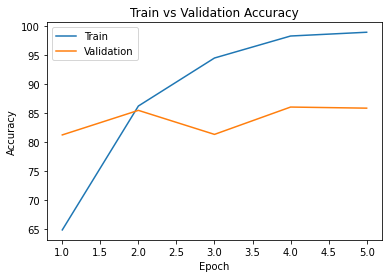

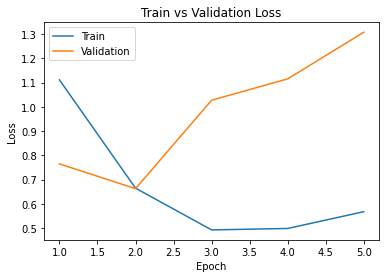

In [ ]:
import matplotlib.pyplot as plt
train_acc = [64.9, 86.25, 94.52, 98.31, 98.96]
val_acc = [81.27, 85.5, 81.36, 86.07, 85.88]
train_loss = [1.111, 0.665, 0.493, 0.499, 0.568]
val_loss = [0.765, 0.663, 1.027, 1.115, 1.307]
plt.title("Train vs Validation Accuracy")
n = 5 # number of epochs
plt.plot(range(1,n+1), train_acc, label="Train")
plt.plot(range(1,n+1), val_acc, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()
plt.title("Train vs Validation Loss")
plt.plot(range(1,n+1), train_loss, label="Train")
plt.plot(range(1,n+1), val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

Train vs validation accuracy for softmax model

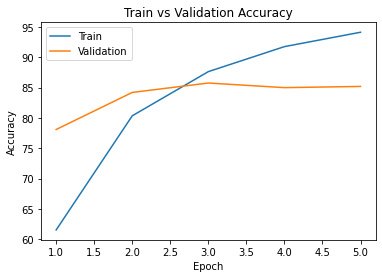

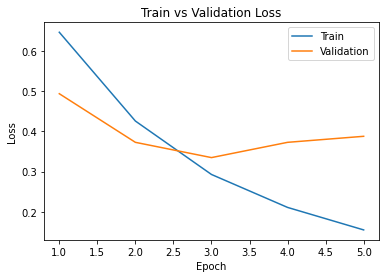

In [ ]:
import matplotlib.pyplot as plt
train_acc = [61.53, 80.34, 87.62, 91.74, 94.11]
val_acc = [78.08, 84.19, 85.74, 84.98, 85.18]
train_loss = [0.647, 0.426, 0.293, 0.211, 0.155]
val_loss = [0.494, 0.373, 0.335, 0.373, 0.388]
plt.title("Train vs Validation Accuracy")
n = 5 # number of epochs
plt.plot(range(1,n+1), train_acc, label="Train")
plt.plot(range(1,n+1), val_acc, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()
plt.title("Train vs Validation Loss")
plt.plot(range(1,n+1), train_loss, label="Train")
plt.plot(range(1,n+1), val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()